

---


# Class incremental learning on the GTSRB dataset



---


This notebook contains several code snippets to help for your project:

- data loaders
- A baseline for incremental learning using fine-tuning
- Examples of how to use Weight & Biases for logging your results.



In [1]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# Useful if you want to store intermediate results on your drive
from google.colab import drive

drive.mount('/content/gdrive/')
DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

Fri Jan 31 11:11:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data loaders

In [4]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [5]:
# Loads datasets (on your local computer)
root_dir = '/home/rodri/OneDrive/Documentos/ENSTA/2A/ML/Incremental-Learning/'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists (not in torchvision dataset)rm *.
import csv
! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/test_target.csv -O data/gtsrb/test_target.csv
test_target=[]
with open('data/gtsrb/test_target.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        test_target += [int(el) for el in row]

! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/train_target.csv -O data/gtsrb/train_target.csv
train_target=[]
with open('data/gtsrb/train_target.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        train_target += [int(el) for el in row]

# Loads class names (not in torchvision dataset)
! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/signnames.csv -O data/gtsrb/signnames.csv
classes = pd.read_csv('data/gtsrb/signnames.csv')
class_names = []
for i, row in classes.iterrows():
    class_names.append(row[1])

Train dataset contains 26640 images
Test dataset contains 12630 images
--2025-01-31 11:11:21--  https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/test_target.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33090 (32K) [text/plain]
Saving to: ‘data/gtsrb/test_target.csv’

data/gtsrb/test_tar 100%[===================>]  32.31K  --.-KB/s    in 0.001s  

2025-01-31 11:11:21 (27.4 MB/s) - ‘data/gtsrb/test_target.csv’ saved [33090/33090]

--2025-01-31 11:11:22--  https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/train_target.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.

<ipython-input-5-f5f0fd534a2f>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_names.append(row[1])


## Display of images

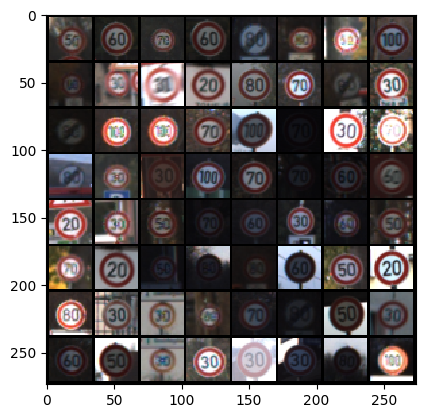

torch.Size([64, 3, 32, 32])


In [6]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


In [7]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Simple networks

In [8]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

# Another simple model (compare them using torchinfo below)
class SimpleCNN2(nn.Module):
    def __init__(self, n_out=10, n_in=1):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc = nn.Linear(128, n_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc(x)
        return x

In [9]:
!pip install torchinfo
from torchinfo import summary

model = SimpleCNN2(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

#print(model)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─ReLU: 1-2                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 32, 16, 16]          --
├─Conv2d: 1-4                            [64, 64, 16, 16]          18,496
├─ReLU: 1-5                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [64, 64, 8, 8]            --
├─Linear: 1-7                            [64, 128]                 524,416
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 395.40
Input size (MB): 0.79
Forward/backward pass size (MB): 25.24
Params size (MB): 2.18
Estimated Tota

## Baseline for incremental learning

In [10]:
from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Simple Training loop
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    for images, labels in tqdm(train_loader, ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def initialize_weights(module):
    """Initializes the weights of a PyTorch module using Xavier/Glorot initialization."""
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):  # Check for relevant layers
        init.xavier_uniform_(module.weight) #Xavier uniform initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize bias to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)): #Initialize normalization layers
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)


# Main training loop for incremental learning
def incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs as needed
            train(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

    return accuracies



## Weight & Biases

You can use this environement to log your learning.

The code below provides a version of the class incremental function that stores learning curves and the seauence of accuracies for each increment of classes.

Tu use it, create an account at: https://wandb.ai/

In [11]:
###################################
##### For using Weight & Biases
###############

!pip install wandb -qU

import wandb

wandb.login()


wandb: Currently logged in as: rodrigozuiani (rodrigozuiani-ensta-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
import math
# Simple Training loop
def train_wandb(model, train_loader, optimizer, criterion, device, epoch):

    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Log train and validation metrics to wandb

    return accuracies



## Pre-Training

In [13]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


Load pre-trained network


## Fine tuning

In [14]:
#############################################
## Fine tuning
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Fine tuning",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Simple Incremental Fine Tuning
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:08, 14.38it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 38.76it/s]


Task 1, Epoch 1: Accuracy Train = 96.11%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 39.79it/s]


Task 1: Accuracy Test = 87.24%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 126it [00:04, 30.94it/s]
100%|█████████████████████████████████████████| 126/126 [00:04<00:00, 30.12it/s]


Task 2, Epoch 1: Accuracy Train = 99.20%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 38.70it/s]


Task 2: Accuracy Test = 47.57%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 49it [00:01, 34.12it/s]
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 38.23it/s]


Task 3, Epoch 1: Accuracy Train = 97.56%


100%|█████████████████████████████████████████| 144/144 [00:03<00:00, 36.41it/s]


Task 3: Accuracy Test = 12.00%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 50it [00:01, 25.36it/s]
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 26.90it/s]


Task 4, Epoch 1: Accuracy Train = 88.99%


100%|█████████████████████████████████████████| 167/167 [00:04<00:00, 37.91it/s]


Task 4: Accuracy Test = 10.00%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 60it [00:01, 34.62it/s]
100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 39.11it/s]


Task 5, Epoch 1: Accuracy Train = 96.96%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 31.09it/s]

Task 5: Accuracy Test = 12.24%


incremental_accuracy,█▄▁▁▁
task,▁▃▅▆█
train/train_loss,▄▃▂▂▂▁▂▁▂▂▁▁▃▂▂▁▂▁▁▁▁▁▁▂▁▄▂▂▂█▇▃▆▅▄▃▂▂▂▁
incremental_accuracy,12.24374
task,4
train/train_loss,0.07375


## Upper bound

In [15]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs

model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


100%|█████████████████████████████████████████| 407/407 [00:14<00:00, 28.90it/s]


Task 1, Epoch 1: Accuracy Train = 97.75%


100%|█████████████████████████████████████████| 407/407 [00:10<00:00, 37.05it/s]


Task 1, Epoch 2: Accuracy Train = 99.17%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 34.36it/s]


Task 1, Epoch 3: Accuracy Train = 99.44%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 34.53it/s]


Task 1, Epoch 4: Accuracy Train = 99.83%


100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 36.76it/s]


Task 1, Epoch 5: Accuracy Train = 99.90%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 31.09it/s]

Task 1: Accuracy Test = 89.90%
!!!!! Upper bound of accuracy = 89.90%


In [16]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = True)

wandb.finish()

Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:03, 34.98it/s]
100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 30.64it/s]


Task 1, Epoch 1: Accuracy Train = 64.70%


100%|███████████████████████████████████████████| 61/61 [00:02<00:00, 29.91it/s]


Task 1: Accuracy Test = 52.22%
Starting Task 2 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 250it [00:07, 34.34it/s]
100%|█████████████████████████████████████████| 250/250 [00:07<00:00, 32.51it/s]


Task 2, Epoch 1: Accuracy Train = 90.70%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 37.80it/s]


Task 2: Accuracy Test = 81.74%
Starting Task 3 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 299it [00:09, 30.41it/s]
100%|█████████████████████████████████████████| 299/299 [00:07<00:00, 37.41it/s]


Task 3, Epoch 1: Accuracy Train = 91.49%


100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 34.25it/s]


Task 3: Accuracy Test = 82.20%
Starting Task 4 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 348it [00:10, 32.56it/s]
100%|█████████████████████████████████████████| 348/348 [00:10<00:00, 33.30it/s]


Task 4, Epoch 1: Accuracy Train = 93.39%


100%|█████████████████████████████████████████| 167/167 [00:04<00:00, 38.47it/s]


Task 4: Accuracy Test = 81.32%
Starting Task 5 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 407it [00:12, 31.64it/s]
100%|█████████████████████████████████████████| 407/407 [00:11<00:00, 34.31it/s]


Task 5, Epoch 1: Accuracy Train = 93.82%


100%|█████████████████████████████████████████| 194/194 [00:05<00:00, 38.43it/s]

Task 5: Accuracy Test = 80.21%


incremental_accuracy,▁████
task,▁▃▅▆█
train/train_loss,▄▄▃▅▅▃▁▇▇▆▅▄▂▁▂▁▇▇▇▆▄▄▄▄▁▁▂███▇▇▆▃▃▂▁▁▁▁
incremental_accuracy,80.20985
task,4
train/train_loss,0.17364


## Avoiding Forgetting

### Rehearsal + KD

In [17]:
import collections

# Rehearsal memory buffer
class MemoryBuffer:
    def __init__(self, size):
        self.size = size
        self.memory = collections.defaultdict(list)  # Store samples per class

    def add_samples(self, images, labels):
        for img, lbl in zip(images, labels):
            # Keep buffer balanced by limiting samples per class
            if len(self.memory[lbl]) > self.size // len(self.memory):
                self.memory[lbl].pop(random.randint(0, len(self.memory[lbl]) - 1))  # Random removal

            self.memory[lbl].append(img)

    def get_samples(self, num_samples):
        samples = []
        classes = list(self.memory.keys())
        if len(self.memory) < num_samples:
            num_samples = len(self.memory)

        while len(samples) < num_samples:
            cls = random.choice(classes)
            if self.memory[cls]:  # Ensure class has data
                samples.append((self.memory[cls].pop(0), cls))  # Pop oldest sample

        return samples

def create_dataloader_rehearsal(dataset, targets, current_classes, batch_size, mem_labels, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes or label in mem_labels]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def get_indices_rehearsal(dataset, targets, current_classes):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    return indices

def get_labels_rehearsal(dataset, targets, current_classes, indices):
    labels = [label for i, label in enumerate(targets) if label in current_classes and i in indices]
    return labels

In [18]:
def distillation_loss(student_outputs, teacher_outputs, temperature=2.0):
    # Ensure student logits only consider old class outputs
    student_outputs = student_outputs[:, :teacher_outputs.shape[1]]

    soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
    soft_preds = nn.functional.log_softmax(student_outputs / temperature, dim=1)

    return nn.functional.kl_div(soft_preds, soft_targets, reduction='batchmean')

In [19]:
# Modified Training loop
def rehearsal_kd_train_wandb(model, train_loader, optimizer, criterion, device, epoch):
    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
    #teacher_model = None

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Knowledge Distillation Loss
        # if teacher_model:
        #     with torch.no_grad():
        #         teacher_outputs = teacher_model(images.to(device))
        #     loss += 0.5 * distillation_loss(outputs[:, :teacher_outputs.shape[1]], teacher_outputs, temperature=2.0)

        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1

# Training loop for modified incremental learning
def rehearsal_kd_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []
    memory_buffer = MemoryBuffer(size=2000)

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        if task == 0:
            train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        else:
            # Rehearsal
            mem_samples = memory_buffer.get_samples(train_loader.batch_size * 2)
            mem_images, mem_labels = zip(*mem_samples)
            mem_labels = torch.tensor(mem_labels).to(device)
            train_loader = create_dataloader_rehearsal(train_dataset, train_target, task_classes, batch_size, mem_labels, shuffle = True)

        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            rehearsal_kd_train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Rehearsal
        indices = get_indices_rehearsal(train_dataset, train_target, task_classes)
        sampled_indices = random.sample(indices, min(200, len(indices)))
        mem_images = []
        mem_labels = get_labels_rehearsal(train_dataset, train_target, task_classes, sampled_indices)
        for i in sampled_indices:
            mem_images.append(train_dataset[i][0])
        memory_buffer.add_samples(mem_images, mem_labels)

        # Update teacher model and memory buffer
        # if task == 0:  # For the first task, initialize the teacher model
        #     teacher_model = copy.deepcopy(model)
        # else:
        #     # Ensure teacher model output layer matches the student model's new architecture
        #     teacher_model.fc = nn.Linear(model.fc.in_features, model.fc.out_features).to(device)

        #     # Copy the entire model's state dictionary with mismatches ignored
        #     teacher_model.load_state_dict(model.state_dict(), strict=False)

    return accuracies


In [20]:
#############################################
## Rehearsal
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Rehearsal",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Incremental with Reheasal
model = copy.deepcopy(copy_model)
rehearsal_kd_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:03, 35.20it/s]
100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 39.16it/s]


Task 1, Epoch 1: Accuracy Train = 96.04%


100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 40.22it/s]


Task 1: Accuracy Test = 87.21%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 207it [00:06, 29.92it/s]
100%|█████████████████████████████████████████| 207/207 [00:05<00:00, 37.93it/s]


Task 2, Epoch 1: Accuracy Train = 97.91%


100%|█████████████████████████████████████████| 122/122 [00:03<00:00, 31.49it/s]


Task 2: Accuracy Test = 76.81%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 175it [00:05, 32.93it/s]
100%|█████████████████████████████████████████| 175/175 [00:04<00:00, 37.88it/s]


Task 3, Epoch 1: Accuracy Train = 99.74%


100%|█████████████████████████████████████████| 144/144 [00:05<00:00, 28.46it/s]


Task 3: Accuracy Test = 53.56%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 263it [00:07, 34.45it/s]
100%|█████████████████████████████████████████| 263/263 [00:08<00:00, 32.22it/s]


Task 4, Epoch 1: Accuracy Train = 99.47%


100%|█████████████████████████████████████████| 167/167 [00:04<00:00, 38.42it/s]


Task 4: Accuracy Test = 68.19%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 279it [00:09, 30.29it/s]
100%|█████████████████████████████████████████| 279/279 [00:07<00:00, 37.93it/s]


Task 5, Epoch 1: Accuracy Train = 99.55%


100%|█████████████████████████████████████████| 194/194 [00:06<00:00, 30.74it/s]


Task 5: Accuracy Test = 68.15%


incremental_accuracy,█▆▁▄▄
task,▁▃▅▆█
train/train_loss,▄▃▃▃▂▂▁▂▁▁▁▁▁▄▂▁▁▁▁▁▄▂▂▂▂▁▁▁▁▂▁█▄▂▂▁▁▁▂▁
incremental_accuracy,68.15174
task,4
train/train_loss,0.00992
